## Fit the CNN on 5000 training cfs3 images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import sys
import shutil
from shutil import copyfile, copy2
from shutil import move

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from scipy import stats
# Cause plots to be displayed in the notebook:
%matplotlib inline

In [4]:
import subprocess 

In [5]:
from matplotlib import cm
from latt2D_modules import calc_diffuse_cfs3
from latt2D_modules import get_occ_map, get_2D_occ_map_from_seq,store_occ_map_as_seq
from latt2D_modules import plot_occ_map,read_bin,output_16bit_pgm
import time

In [6]:
from tensorflow import keras
from tensorflow.keras import layers


2023-05-11 15:13:35.654449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import h5py
from keras.callbacks import ModelCheckpoint

In [8]:
# read in all the correlation datum  
df_cfs3=pd.read_csv('output_correlations_cfs3_5000.csv')
df_cfs3=df_cfs3.drop('Unnamed: 0',axis=1)
df_cfs3.reset_index(inplace=True,drop=True)
df_cfs3.head()

,00,01,02,10,11,12,20,21,22
0,0.998976,0.307776,-0.370624,0.366976,0.205376,0.074176,0.430976,-0.033024,-0.383424
1,0.999744,-0.403456,0.266944,-0.022656,-0.094656,-0.440256,0.258944,-0.720256,0.486144
2,0.999997,0.001597,0.323197,0.417597,-0.009603,-0.110403,-0.164803,-0.337603,-0.184003
3,0.997379,-0.244221,-0.426621,-0.103421,-0.493821,0.571779,0.106179,-0.183421,0.213379
4,0.999994,0.105594,-0.182406,0.212794,-0.366406,-0.036806,-0.459206,-0.152006,-0.251206


In [9]:
y=df_cfs3.iloc[:,1:9].values

In [10]:
y[0]

array([ 0.307776, -0.370624,  0.366976,  0.205376,  0.074176,  0.430976,
       -0.033024, -0.383424])

In [13]:
my_cols=df_cfs3.columns.values
my_cols

array(['00', '01', '02', '10', '11', '12', '20', '21', '22'], dtype=object)

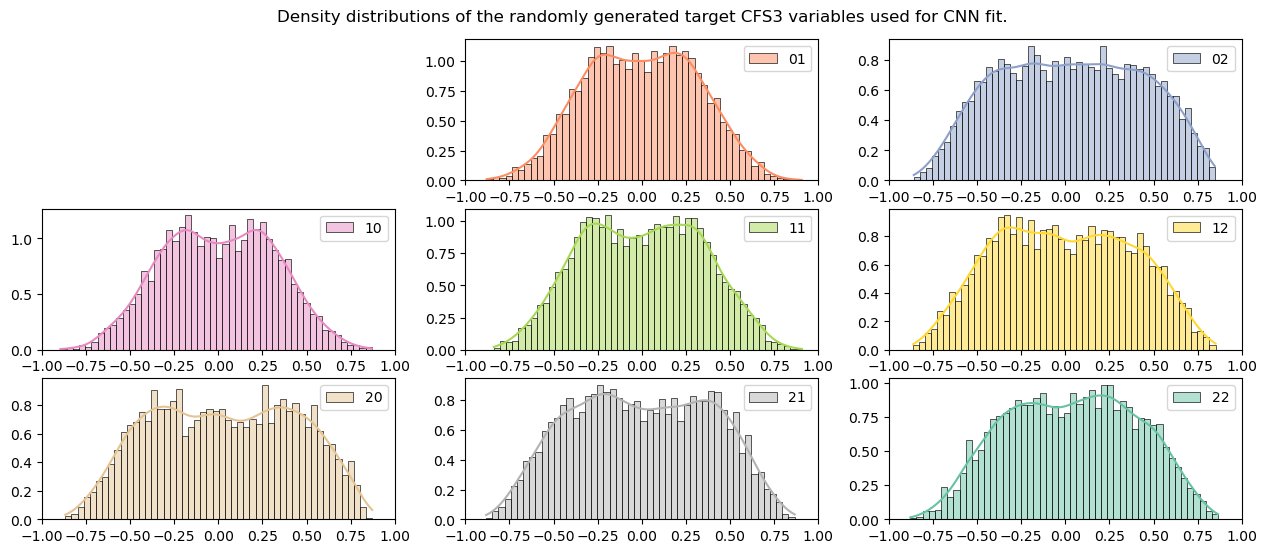

In [14]:

palette = sns.color_palette("Set2", n_colors=9)
rows,cols =3,3 
fig, axes = plt.subplots(rows, cols, figsize=(15,6))
k=0
for i in range(rows): 
    for j in range(cols):
        mycol=my_cols[k]
        sns.histplot(ax=axes[i,j], data=df_cfs3, x=mycol, bins=50,color=palette[k] , kde=True, stat='density', label='%s'%mycol )
        axes[i,j].set_xlabel(None)
        axes[i,j].set_ylabel(None)
        axes[i,j].set_xlim([-1,1])
        axes[i,j].legend(loc=1)
        k+=1

fig.suptitle("Density distributions of the randomly generated target CFS3 variables used for CNN fit.", fontsize=12, y=0.95)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)

axes[0, 0].remove()  # remove unused subplot
# plt.legend()

In [18]:
# Open the HDF5 file in read-only mode
with h5py.File('cfs3_image_dataset_5000.h5', 'r') as f:
    # Get a list of dataset names in the HDF5 file
    dataset_names = list(f.keys())
    
    # Print the names of all datasets
    for name in dataset_names:
        print(name)
    dset=f[dataset_names[0]]
    X=dset[:]

cfs3_img_data


In [19]:
print(np.shape(y))
print(np.shape(X))

(5000, 8)
(5000, 64, 64)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2)

In [21]:
X_train=np.expand_dims(X_train, -1)
X_test=np.expand_dims(X_test, -1)

In [22]:
print(np.shape(X_train),type(X_train))
print(np.shape(X_test),type(X_test))
print(np.shape(y_train),type(y_train))
print(np.shape(y_test),type(y_test))

(4000, 64, 64, 1) <class 'numpy.ndarray'>
(1000, 64, 64, 1) <class 'numpy.ndarray'>
(4000, 8) <class 'numpy.ndarray'>
(1000, 8) <class 'numpy.ndarray'>


In [26]:
input_shape = (64, 64, 1)
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu",name='conv1'),
        layers.BatchNormalization(name='norm1'),
        layers.MaxPooling2D(pool_size=(2, 2),name='maxpool1'),
        layers.Dropout(0.2,name='drop1'),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu",name='conv2'),
        layers.BatchNormalization(name='norm2'),
        layers.MaxPooling2D(pool_size=(2, 2),name='maxpool2'),
        layers.Flatten(name='flatten1'),
        layers.Dropout(0.5,name='drop2'),
        layers.Dense(8, activation="linear",name='dense_out'),
    ],name='seq_CNN_cfs3'
)

model.summary()

Model: "seq_CNN_cfs3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 62, 32)        320       
                                                                 
 norm1 (BatchNormalization)  (None, 62, 62, 32)        128       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 31, 31, 32)        0         
                                                                 
 drop1 (Dropout)             (None, 31, 31, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 64)        18496     
                                                                 
 norm2 (BatchNormalization)  (None, 29, 29, 64)        256       
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 64)       

In [16]:
# Load the saved weights into the model
# model.load_weights('best_model.h5')

In [27]:
batch_size = 32
epochs = 100
# Define checkpoint callback
checkpoint = ModelCheckpoint('cfs3_best_model_5000.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# opt = keras.optimizers.Adam(learning_rate=0.01) # not using this atm
model.compile(loss="mse", optimizer="adam", metrics=[MeanSquaredError(),MeanAbsoluteError()])

In [28]:

history =model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])

# ## Evaluate the trained model

# In[ ]:

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 7.9795 - mean_squared_error: 7.9795 - mean_absolute_error: 2.0952
Epoch 1: val_loss improved from inf to 0.19365, saving model to best_model_5000.h5
100/100 [==============================] - 7s 68ms/step - loss: 7.9795 - mean_squared_error: 7.9795 - mean_absolute_error: 2.0952 - val_loss: 0.1937 - val_mean_squared_error: 0.1937 - val_mean_absolute_error: 0.3450
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.5759 - mean_squared_error: 4.5759 - mean_absolute_error: 1.6192
Epoch 2: val_loss did not improve from 0.19365
100/100 [==============================] - 7s 74ms/step - loss: 4.5759 - mean_squared_error: 4.5759 - mean_absolute_error: 1.6192 - val_loss: 0.2794 - val_mean_squared_error: 0.2794 - val_mean_absolute_error: 0.4080
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 3.2615 - mean_squared_error: 3.2615 - mean_absolute_error: 1.3842
Epoch 3: val_loss did not i

In [29]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test mae:", score[2])

32/32 [==============================] - 1s 19ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0322
Test loss: 0.0018693178426474333
Test mae: 0.03223636373877525


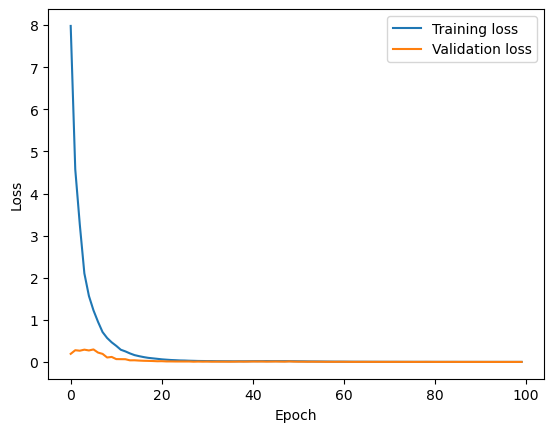

In [30]:
# Plot the training and validation loss as a function of the epoch
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [31]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
r2 = r2_score(y_test.flatten(), y_pred.flatten())
print("Test R2 score:", r2)

32/32 [==============================] - 0s 10ms/step
Test R2 score: 0.9861103222644254


In [32]:
m,b=np.polyfit(y_test.flatten(),y_pred.flatten(),1)
xs=np.linspace(-1,1,10)
ys=m*xs+b

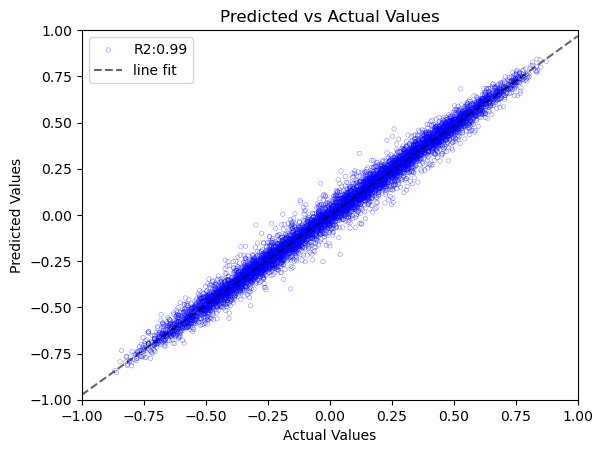

In [55]:
ax=sns.scatterplot(x=y_test.flatten(),y=y_pred.flatten(),marker='o',edgecolor='b',c='none',s=10,alpha=0.7,label='R2:%.2f'%r2)
ax=plt.plot(xs,ys,c='k',marker='none',linestyle='--',alpha=0.6,label='line fit')
ax=plt.legend()
ax=plt.xlim([-1.0,1.0])
ax=plt.ylim([-1.0,1.0])
ax=plt.margins(0.25)
ax=plt.xlabel('Actual Values')
ax=plt.ylabel('Predicted Values')
ax=plt.title('Predicted vs Actual Values')

## done some more EDA on the actual data so that we can get some idea of predictive power but also 
## exactly how sensitive is the model is to outliers  

### the below histogram means that any data fed into the model 
### should roughly scale with the same distribution of intensities 
the best way to do this is might be to just draw a straight line through the logplot version of the histogram 
sicne there is information that is so weak it is less useful 

0.25221753930505236
0.07935997098684311
37.922061920166016
0.0012111817486584187


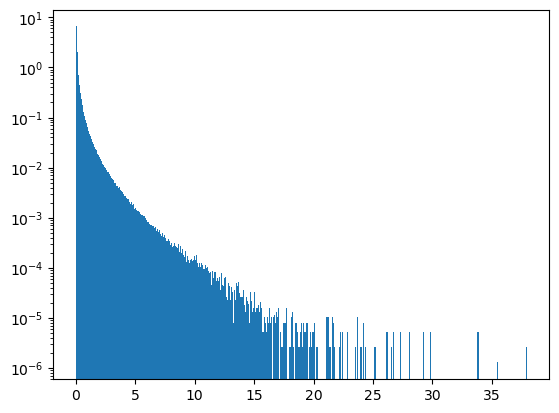

In [34]:
ax=plt.hist(X.flatten(),bins=1000,log=True,density=True)
print(np.mean(X.flatten()))
print(np.median(X.flatten()))
print(np.max(X.flatten()))
print(np.min(X.flatten()))

In [35]:
iconc=0.50 # spin concentration
cread=0    # reading correlation function from input file  otherwise it will be generated randomly 
'corr.in'
'jswitch.in'
icycles=300  # MC cycles 
ianneal=300  # MC input 

In [36]:

# np.shape(X_test[xvar].reshape((64,-1)))
# ax=imshow(np.flip(X_test[xvar].reshape((64,-1)),0),cmap='gray')

xvar=np.random.randint(0,np.shape(X_test)[0],1)[0]   
y_pred = model.predict(X_test)

y_pred[xvar]
# np.shape(X_test[xvar])
#imshow(np.transpose(occ2d),interpolation='nearest',cmap='gray')

32/32 [==============================] - 0s 9ms/step


array([-0.5264815 ,  0.09373988,  0.38783097,  0.02074676, -0.46694082,
       -0.188132  ,  0.46894872, -0.70139426], dtype=float32)

In [39]:
def get_metrics_ypred_ytest(xvar):
    corr_test=y_test[xvar]
    corr_pred=y_pred[xvar]
    r2y = r2_score(corr_test, corr_pred)
    msey=mean_squared_error(corr_test, corr_pred)
    maey=mean_absolute_error(corr_test, corr_pred)
    return [r2y,msey,maey]    
    

In [58]:
def get_metrics_compare_regens_test_set(xvar,exp=1):   
    corr_in=y_test[xvar]
    corr_in=np.r_[1.0,corr_in]
    corr_out=np.loadtxt('./expfiles_%d/corr.out'%exp)
    imdat_0 = X_test[xvar].reshape((64,-1))
    imdat_1 = read_bin('./expfiles_%d/hk0.bin'%exp, npixels=64, offset=1280)
    
  #  print(corr_in, corr_out.flatten())
  #  print(np.shape(imdat_0)) 
  #  print(np.shape(imdat_1))
    r2c = r2_score(corr_in.flatten(), corr_out.flatten())
    msec=mean_squared_error(corr_in,corr_out.flatten())
    maec=mean_absolute_error(corr_in,corr_out.flatten())

    r2i=r2_score(imdat_0.flatten(),imdat_1.flatten())
    msei=mean_squared_error(imdat_0.flatten(),imdat_1.flatten())
    maei=mean_absolute_error(imdat_0.flatten(),imdat_1.flatten())
    return [r2c,msec,maec,r2i,msei,maei]    

# get_metrics_compare_regens_test_set(xvar,exp=1)

In [50]:
# Create a figure and axis for the plot
# Define a function to update the plot
def update_plot_regen(xvar):
    
    rows,cols =1,3 
    fig, axes = plt.subplots(rows, cols, figsize=(6,6))

   
    imdat = X_test[xvar].reshape((64,-1))
    axes[0].imshow(np.flip(imdat,0),cmap='gray')
    axes[0].axis("off")

    corrin=y_test[xvar]
    fhout=open('corr.in','w')
    fhout.write("1.000000 %.6f %.6f\n%.6f %.6f %.6f\n%.6f %.6f %.6f\n"%(tuple(corrin.flatten())))
    fhout.close()
    calc_diffuse_cfs3(iconc,1,icycles,ianneal,1) # do the regen on the image  
    
    occ3D=get_occ_map('./expfiles_1/ising2D_occ.txt')
    axes[1].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
    axes[1].axis("off")
    imdat = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
    axes[2].imshow(np.flip(imdat,0),cmap='gray')
    axes[2].axis("off")
    
    my_metrics=get_metrics_compare_regens_test_set(xvar)
    fig.suptitle(" metrics(r2, mse, mae)\n corrfunc: %.3f, %.3f, %.3f \n FT_metrics: %.3f, %.3f, %.3f " %(tuple(my_metrics)), fontsize=10,y=0.73)
    

In [98]:
# Create a figure and axis for the plot
# Define a function to update the plot
def update_plot_ypred(xvar):
    rows,cols =1,3 
    fig, axes = plt.subplots(rows, cols, figsize=(6,6))
   
    imdat = X_test[xvar].reshape((64,-1))
    axes[0].imshow(np.flip(imdat,0),cmap='gray')
    axes[0].axis("off")

    corrin=y_pred[xvar]
    fhout=open('corr.in','w')
    fhout.write("1.000000 %.6f %.6f\n%.6f %.6f %.6f\n%.6f %.6f %.6f\n"%(tuple(corrin.flatten())))
    fhout.close()
    calc_diffuse_cfs3(iconc,1,icycles,ianneal,1) # do the regen on the image  
    
    occ3D=get_occ_map('./expfiles_1/ising2D_occ.txt')
    axes[1].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
    axes[1].axis("off")
    imdat = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
    axes[2].imshow(np.flip(imdat,0),cmap='gray')
    axes[2].axis("off")
    
    my_metrics=get_metrics_compare_regens_test_set(xvar)
    my_metrics2=get_metrics_ypred_ytest(xvar)
    fig.suptitle("metrics(r2, mse, mae)\n corrfunc: %.3f, %.3f, %.3f \n FT_metrics: %.3f, %.3f, %.3f" %tuple(my_metrics) + "\n corrfunc test vs. pred: %.3f, %.3f, %.3f" %(my_metrics2[0], my_metrics2[1], my_metrics2[2]), fontsize=10, y=0.73)
     

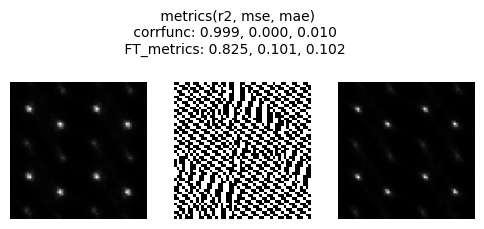

In [62]:
xvar=np.random.randint(0,np.shape(X_test)[0],1)[0]
update_plot_regen(xvar)
# get_metrics_compare_regens_test_set(xvar)

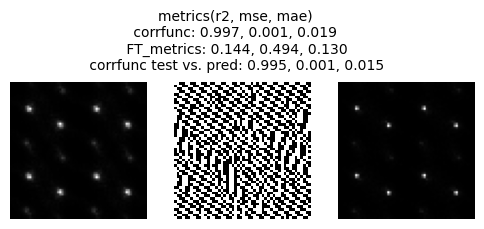

In [99]:
update_plot_ypred(xvar)  

In [64]:
#### might have to block average these metrics to get a better variance 
#### wonder what happens when i put other types of images into the model 

print(" metrics(r2, mse, mae)\n corrfunc test vs. pred: %.3f, %.3f, %.3f \n " %(tuple(get_metrics_ypred_ytest(xvar))))

 metrics(r2, mse, mae)
 corrfunc test vs. pred: 0.995, 0.001, 0.015 
 
